In [18]:
from PIL import Image
import numpy as np
import itertools
import cv2
from matplotlib import pyplot as plt

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Step 1 - Design and build a dataset $X$ for character recognition of 20 16x16-pixel images (256 pixels per image) from online exemplars.

In [20]:
#Convert it to SIFT
thresh = 150
gif = cv2.VideoCapture('alphabet.gif')
ret, frame = gif.read()
cv2.imwrite('alphabet.jpeg', frame)

True

In [21]:
img = cv2.imread('alphabet.jpeg')
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
(thresh, blackAndWhiteImage) = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
kp = sift.detect(blackAndWhiteImage,None)
#need to create this color flip to remove noisy drawing SIFT key points, to better preprocessed the image
img =cv2.drawKeypoints(blackAndWhiteImage,kp,img,(255,255,255),flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite('sift_keypoints.jpg',img)

True

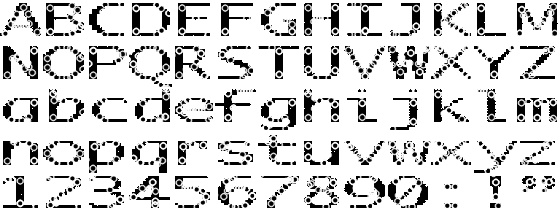

In [22]:
im_drawed = Image.open('sift_keypoints.jpg')
im_drawed

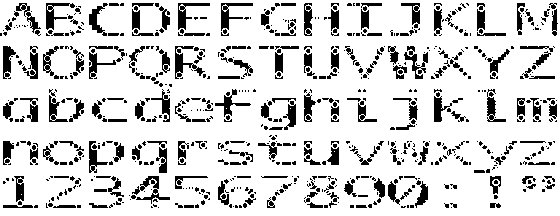

In [23]:
# convert image to black and white
fn = lambda x : 255 if x > thresh else 0
im = im_drawed.convert('L').point(fn, mode='1')
im

In [24]:
np.array(im)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [25]:
w, h = im.size
print('width: ', w)
print('height:', h)

width:  560
height: 216


In [26]:
# list(im.getdata())

In [27]:
image_height = 16
image_width = 16
m = 13
n = 5
image_size = image_height*image_width
im_resize = im.resize((m*image_width, n*image_height))

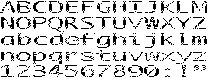

In [28]:
im_resize

In [29]:
pix = np.array(im_resize)
nrow, ncol = pix.shape
print(pix.shape)
print(pix.dtype)
# chanage the data type from bool to double
pix = pix.astype(np.float32)
print(pix.dtype)

(80, 208)
bool
float32


In [30]:
# construct the training dataset, validation dataset and testing dataset
n_train_sample = 32
n_val_sample = 16
n_test_sample = 32
n_channel  = 1
dataset_train = np.ndarray(shape=(n_train_sample, n_channel, image_height, image_width), dtype=np.float32)
dataset_train.shape
dataset_train.dtype
dataset_val = np.ndarray(shape=(n_val_sample, n_channel, image_height, image_width), dtype=np.float32)
dataset_val.shape
dataset_val.dtype
dataset_test = np.ndarray(shape=(n_test_sample, n_channel, image_height, image_width), dtype=np.float32)
dataset_test.shape
dataset_test.dtype

dtype('float32')

In [31]:
#create train
idx = 0
for i in range(5):
    for j in range(13):
        if( (i == 0 or i == 2) and ( 0 <= j <= 11) ):
            x = pix[(i*image_height):( (i+1)*image_height), (j*image_width):( (j+1)*image_width)]
            dataset_train[idx] = x
            idx += 1
        if( (i == 4) and (( 0 <= j <= 5) or (10 <= j <= 11))):
            x = pix[(i*image_height):( (i+1)*image_height), (j*image_width):( (j+1)*image_width)]
            dataset_train[idx] = x
            idx += 1
            
#create val
idx = 0
for i in range(5):
    for j in range(13):
        if( (i == 0 or i == 2) and ( 0 <= j <= 5) ):
            x = pix[(i*image_height):( (i+1)*image_height), (j*image_width):( (j+1)*image_width)]
            dataset_val[idx] = x
            idx += 1
            
        if( (i == 4) and ( 0 <= j <= 3) ):
            x = pix[(i*image_height):( (i+1)*image_height), (j*image_width):( (j+1)*image_width)]
            dataset_val[idx] = x
            idx += 1
            

#create test
idx = 0
for i in range(5):
    for j in range(13):
        if( (i == 0 or i == 2) and ( j == 12) ):
            x = pix[(i*image_height):( (i+1)*image_height), (j*image_width):( (j+1)*image_width)]
            dataset_test[idx] = x
            idx += 1
        if( (i == 1 or i == 3) and ( 0 <= j <= 12) ):
            x = pix[(i*image_height):( (i+1)*image_height), (j*image_width):( (j+1)*image_width)]
            dataset_test[idx] = x
            idx += 1
        if( (i == 4) and ( 6 <= j <= 9) ):
            x = pix[(i*image_height):( (i+1)*image_height), (j*image_width):( (j+1)*image_width)]
            dataset_test[idx] = x
            idx += 1
print("All images to array!")

All images to array!


In [32]:
dataset_train.shape

(32, 1, 16, 16)

In [33]:
dataset_val.shape

(16, 1, 16, 16)

In [34]:
dataset_test.shape

(32, 1, 16, 16)

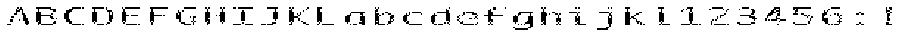

In [35]:
#print train
fig, axs = plt.subplots(1, 32 ,figsize=(16,16))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_train):
        ax.imshow(dataset_train[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

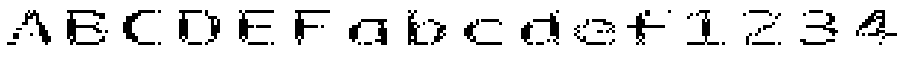

In [36]:
#print val
fig, axs = plt.subplots(1, 16 ,figsize=(16,16))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_val):
        ax.imshow(dataset_val[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

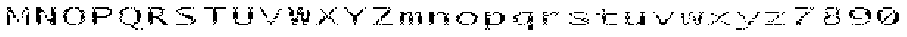

In [37]:
#print test
fig, axs = plt.subplots(1, 32 ,figsize=(16,16))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_test):
        ax.imshow(dataset_test[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

In [38]:
dataset_train_reshaped = dataset_train.reshape((n_train_sample, 1, -1))
dataset_val_reshaped = dataset_val.reshape((n_val_sample, 1, -1))
dataset_test_reshaped = dataset_test.reshape((n_test_sample, 1, -1))

In [39]:
dataset_train_reshaped.shape

(32, 1, 256)

## Step 2 - Design and develop two (MLNN) in Python, using libraries such as PyTorch (and, if necessary, Tensor Flow). 
